<a href="https://colab.research.google.com/github/daniui/Machine-Learning-Project/blob/main/Analisis%20Data%20Tidak%20Terstruktur/Bert_for_sequce_classifcation_(trainingarguments_GPU).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Loading
1. digunakan modul kagglehub untuk melakukan pengunduhan dataset secara langsung dar kaggle
2. Selanjutnya dilakukan data loading dengan membaca teks dari file dalam subdirektori.

In [ ]:
import kagglehub

# Download latest version
datapath = kagglehub.dataset_download("shivamkushwaha/bbc-full-text-document-classification")

print("Path to dataset files:", datapath)

100%|██████████| 5.59M/5.59M [00:00<00:00, 38.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shivamkushwaha/bbc-full-text-document-classification/versions/1


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Get the file details
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
import nltk
from nltk.corpus import stopwords
from transformers import BertTokenizer


directory = []
file = []
title = []
text = []
label = []
#datapath = '/content/bbc-full-text-document-classification'
for dirname, _ , filenames in os.walk(datapath):
    #print('Directory: ', dirname)
    #print('Subdir: ', dirname.split('/')[-1])
    # remove the Readme.txt file
    # will not find file in the second iteration so we skip the error
    try:
        filenames.remove('README.TXT')
    except:
        pass
    for filename in filenames:
        directory.append(dirname)
        file.append(filename)
        label.append(dirname.split('/')[-1])
        fullpathfile = os.path.join(dirname,filename)
        with open(fullpathfile, 'r', encoding="utf8", errors='ignore') as infile:
            intext = ''
            firstline = True
            for line in infile:
                if firstline:
                    title.append(line.replace('\n',''))
                    firstline = False
                else:
                    intext = intext + ' ' + line.replace('\n','')
            text.append(intext)

...

In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'

fulldf = pd.DataFrame(list(zip(directory, file, title, text, label)),
               columns =['directory', 'file', 'title', 'text', 'label'])

df = fulldf.filter(['text','label'], axis=1)
df

text  label
0       France have brought flanker Serge Betsen bac...  sport
1       Carlos Moya described Spain's Davis Cup vict...  sport
2       Second seed Andre Agassi suffered a comprehe...  sport
3       Scotland manager Walter Smith has given his ...  sport
4       Juninho's agent has confirmed that the playe...  sport
...                                                 ...    ...
4445    A team of US researchers has shown that cont...   tech
4446    Civil liberties group the Electronic Frontie...   tech
4447    Mobile phones are still enjoying a boom time...   tech
4448    First it was the humble home video, then it ...   tech
4449    Robots are learning lessons on "robotiquette...   tech

[4450 rows x 2 columns]

#Persebaran Target

Melihat persebaran data target, dapat dilihat bahwa persebaran cukup merata

<Axes: xlabel='label'>

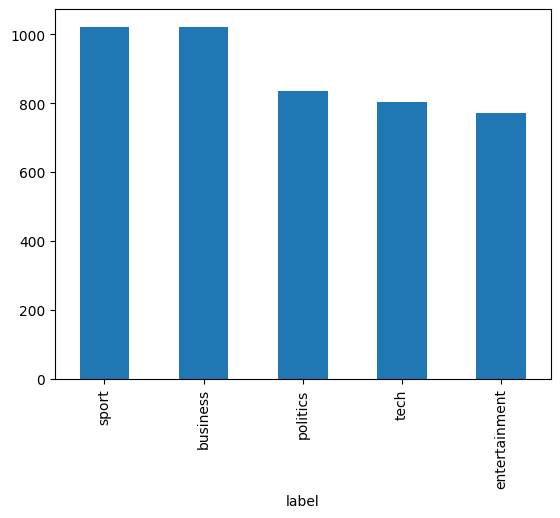

In [ ]:
df['label'].value_counts().sort_values(ascending=False).plot(kind='bar')

#Data Preprocessing

Pendekatan data preprocessing ini bertujuan untuk membersihkan dan menstandarisasi dengan mengubah semua teks kapital menjadi kecil, menghapus simbol, mengahpus stopwords, menghapus angka dan mengubah target yang masih dalam bentuk kategorik ke numerik.

In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
#     text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

In [ ]:
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].str.replace('\d+', '')
df

text  label
0     france brought flanker serge betsen back squad...  sport
1     carlos moya described spains davis cup victory...  sport
2     second seed andre agassi suffered comprehensiv...  sport
3     scotland manager walter smith given backing re...  sport
4     juninhos agent confirmed player hoping talks m...  sport
...                                                 ...    ...
4445  team us researchers shown controlling devices ...   tech
4446  civil liberties group electronic frontier foun...   tech
4447  mobile phones still enjoying boom time sales a...   tech
4448  first humble home video dvd hollywood preparin...   tech
4449  robots learning lessons robotiquette behave so...   tech

[4450 rows x 2 columns]

In [ ]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
df

text  label
0     france brought flanker serge betsen back squad...      3
1     carlos moya described spains davis cup victory...      3
2     second seed andre agassi suffered comprehensiv...      3
3     scotland manager walter smith given backing re...      3
4     juninhos agent confirmed player hoping talks m...      3
...                                                 ...    ...
4445  team us researchers shown controlling devices ...      4
4446  civil liberties group electronic frontier foun...      4
4447  mobile phones still enjoying boom time sales a...      4
4448  first humble home video dvd hollywood preparin...      4
4449  robots learning lessons robotiquette behave so...      4

[4450 rows x 2 columns]

Pendekatan tokenizer ini menggunakan BERT Tokenizer `BertTokenizer.from_pretrained('bert-base-cased')` untuk mengubah teks menjadi format token yang dapat diproses oleh model BERT. Langkah-langkahnya:
1. Memisahkan Data:
`train_test_split(df['text'], df['label'], test_size=0.2)` membagi data menjadi 80% training set dan 20% validation set.
2. Tokenisasi dengan BERT:
Menggunakan BertTokenizer.from_pretrained('bert-base-cased'), yaitu tokenizer dari model BERT base yang peka terhadap kapitalisasi (cased).
Tokenisasi dan Padding dilakukan dengan `tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)`
    - truncation=True: Memotong teks yang lebih panjang dari 128 token padding=True: Menambahkan padding agar semua teks memiliki panjang yang sama (128 token).
    - max_length=128: Menentukan panjang maksimum input agar sesuai dengan batasan model BERT.


In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(df['text'], df['label'], test_size=0.2)
train_texts


3907    robert de niro completed transatlantic box off...
1510    charttopping pop band busted confirmed plan ta...
2444    goals gregory vignal nacho novo gave rangers s...
2777    labour tories clashed tax spending plans row g...
2035    web helping aid agencies gather resources help...
                              ...                        
2526    worst kept secret scottish football revealed t...
3213    japanese communications firm softbank widened ...
4242    us poised push japan top supercomputing chart ...
2922    tony blairs feud gordon brown damaging way uk ...
4106    worlds dwindling panda population getting help...
Name: text, Length: 3560, dtype: object

In [ ]:
# Tokenize the texts
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)
train_encodings

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

{'input_ids': [[101, 11580, 3740, 1260, 11437, 2180, 2063, 14715, 2980, 9180, 1596, 2884, 1701, 2702, 27001, 26006, 1366, 1273, 5896, 1160, 1472, 2441, 1159, 3789, 8047, 2283, 175, 5559, 1468, 2940, 26181, 1253, 1200, 6693, 1394, 16358, 3101, 1399, 2927, 6766, 188, 7877, 21599, 1181, 2046, 1499, 26006, 3481, 5138, 1261, 5117, 1306, 1210, 1552, 2022, 1551, 1295, 1160, 2739, 5937, 26757, 1492, 1503, 1159, 1366, 9569, 1207, 11826, 4750, 5622, 2283, 175, 5559, 1468, 11606, 1648, 1146, 3121, 10245, 1401, 4252, 6052, 3677, 1539, 1855, 3789, 2283, 2153, 1992, 13660, 1648, 4750, 5622, 12361, 5367, 2399, 8244, 1200, 2133, 5421, 18298, 1910, 3587, 13392, 26006, 2884, 1701, 3481, 2283, 175, 5559, 1468, 2873, 2739, 1499, 3205, 2021, 2168, 2523, 5937, 26757, 1492, 3937, 11333, 179, 1161, 3013, 102], [101, 3481, 9870, 2624, 3618, 1467, 16118, 1174, 3659, 2197, 1321, 2549, 1378, 23620, 18691, 15601, 4195, 4393, 1647, 1419, 8462, 1163, 25063, 22572, 1813, 7174, 27466, 15279, 1320, 2919, 4511, 1159, 16

#Training

Pendekatan ini membuat custom PyTorch Dataset (SimpleDataset) yang mengemas tokenized encodings dan label ke dalam format PyTorch tensors, memungkinkan penggunaan dataset ini dalam DataLoader untuk pelatihan model berbasis deep learning

In [ ]:
#Create pytorch Dataset
import torch
from torch.utils.data import Dataset

class SimpleDataset:
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SimpleDataset(train_encodings, train_labels.tolist())
val_dataset = SimpleDataset(val_encodings, val_labels.tolist())

...

Pendekatan ini memuat model BERT (BertForSequenceClassification) yang telah dipra-latih (pretrained) dengan arsitektur bert-base-cased, kemudian menyesuaikannya untuk klasifikasi teks dengan jumlah label yang sesuai berdasarkan jumlah kelas unik dalam dataset dan menjalankannya di GPU (cuda) atau CPU, tergantung pada ketersediaan perangkat keras.

In [ ]:
#Load BERT Model
from transformers import BertForSequenceClassification

# 4. Model initialization
model = BertForSequenceClassification.from_pretrained(
    'bert-base-cased',
    num_labels=len(df['label'].unique())
).to('cuda' if torch.cuda.is_available() else 'cpu')
model

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

...

Pendekatan ini **menggunakan `Trainer` dari Hugging Face's Transformers** untuk **melatih model BERT** dengan **pengaturan training (`TrainingArguments`)**, seperti jumlah epoch, ukuran batch, strategi evaluasi, penyimpanan model terbaik, dan logging. Model kemudian **dilatih (`trainer.train()`)** serta **dievaluasi (`trainer.evaluate()`)** untuk mendapatkan metrik performa akhir.

In [ ]:
# Metrics
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    report_to="none",  # Disables WandB
    num_train_epochs=4,
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=torch.cuda.is_available(),  # Enable mixed precision training if GPU is available
    dataloader_num_workers=8,  # Utilize multiple CPU cores for data loading
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# This will print all metrics to console
trainer.train()

# Final evaluation
results = trainer.evaluate()
print("Final results:", results)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T

Final results: {'eval_loss': 0.06421756744384766, 'eval_runtime': 2.4555, 'eval_samples_per_second': 362.452, 'eval_steps_per_second': 45.612, 'epoch': 4.0}


In [ ]:
import numpy as np
predictions = trainer.predict(val_dataset)
predictions_label = np.argmax(predictions.predictions, axis=-1)
true_label = val_labels.numpy() if torch.is_tensor(val_labels) else np.array(val_labels)
true_label

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


array([4, 0, 1, 3, 3, 0, 2, 0, 4, 1, 3, 0, 3, 0, 0, 2, 4, 0, 1, 4, 0, 1,
       0, 0, 0, 3, 4, 1, 0, 1, 4, 3, 3, 2, 4, 3, 1, 2, 1, 4, 4, 4, 4, 1,
       1, 4, 2, 2, 0, 1, 2, 4, 0, 3, 3, 3, 0, 3, 1, 2, 2, 4, 0, 4, 1, 0,
       4, 0, 0, 1, 3, 3, 4, 2, 2, 0, 3, 3, 0, 0, 2, 3, 3, 0, 3, 0, 0, 2,
       4, 1, 0, 4, 1, 3, 4, 2, 2, 0, 2, 2, 0, 0, 0, 3, 3, 2, 2, 0, 3, 0,
       2, 4, 4, 2, 4, 0, 4, 3, 2, 3, 0, 0, 0, 2, 2, 1, 2, 1, 4, 0, 0, 4,
       0, 3, 3, 1, 2, 4, 3, 0, 3, 3, 4, 2, 0, 3, 2, 0, 2, 3, 3, 0, 1, 2,
       4, 0, 3, 0, 1, 4, 2, 1, 4, 0, 0, 3, 3, 3, 1, 0, 3, 2, 4, 1, 3, 3,
       4, 4, 4, 0, 2, 2, 4, 3, 0, 3, 0, 2, 1, 3, 0, 1, 0, 3, 0, 3, 0, 3,
       1, 1, 1, 1, 2, 3, 0, 0, 0, 2, 2, 1, 4, 4, 4, 2, 4, 3, 4, 1, 2, 0,
       1, 0, 4, 1, 3, 3, 3, 2, 4, 0, 2, 0, 2, 4, 2, 3, 4, 3, 3, 2, 3, 4,
       0, 0, 1, 4, 0, 0, 4, 0, 0, 4, 1, 3, 2, 3, 2, 0, 3, 0, 0, 3, 1, 1,
       3, 2, 2, 4, 3, 4, 3, 3, 3, 0, 4, 3, 4, 0, 0, 4, 1, 1, 2, 2, 0, 2,
       2, 0, 1, 0, 4, 1, 2, 4, 4, 1, 3, 2, 4, 1, 1,

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

accuracy = accuracy_score(true_label, predictions_label)
print(accuracy)
cm = confusion_matrix(true_label, predictions_label)
print(cm)

0.9910112359550561
[[207   0   0   0   2]
 [  0 141   0   0   0]
 [  2   0 164   0   2]
 [  0   0   0 206   0]
 [  0   0   2   0 164]]


Didapat hasil akurasi akhir yang tinggi yaitu 0.991, model perform dengan baik